### See how a model performs on the congruent and incongruent test samples

In [1]:
import os, sys
import torch
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

sys.path.insert(0, 'src')
from utils.visualizations import show_image_rows, make_grid, plot
from utils import read_lists

import model.metric as module_metric

In [2]:
dataset_type = '2_Spurious_MNIST'
data_root_dir = os.path.join('data')
train_path = os.path.join(data_root_dir, dataset_type, 'training.pt')
train_data = torch.load(train_path)

test_path = os.path.join(data_root_dir, dataset_type, 'test.pt')
test_data = torch.load(test_path)

### Load colors and labels for test set

In [ ]:
# train_imgs = train_data['images']
# train_labels = train_data['labels']

# test_imgs = test_data['images']
# test_labels = test_data['labels']

n_show = 20
for idx, data in enumerate([train_data, test_data]):
    imgs = data['images']
    labels = data['labels']
    print(imgs[0].shape)
    print(np.amax(imgs[0]))
    show_imgs = imgs[:n_show]
    show_labels = labels[:n_show]
    show_imgs = make_grid(show_imgs, items_per_row=5)
    show_labels = make_grid(show_labels, items_per_row=5)
    show_image_rows(
        images=show_imgs,
        image_titles=show_labels,
        image_size=(1.5, 1.5),
        figure_title='{} {}'.format(dataset_type, 'Train' if idx == 0 else 'Test'))


In [6]:
dataset_type = '2_Spurious_MNIST'

data_dir = os.path.join('data', dataset_type)
test_data_path = os.path.join(data_dir, 'test.pt')

test_data = torch.load(test_data_path)
test_labels = np.array(test_data['labels'])
test_colors = np.array(test_data['colors'])

congruent_idxs_path = os.path.join(data_dir, 'test_congruent_idxs.pt')
incongruent_idxs_path = os.path.join(data_dir, 'test_incongruent_idxs.pt')

congruent_idxs = torch.load(congruent_idxs_path)
incongruent_idxs = torch.load(incongruent_idxs_path)

In [166]:
trial_paths_path = 'saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/trial_paths.txt'
trial_paths = read_lists(trial_paths_path)
trial_dir = os.path.dirname(trial_paths_path)


In [146]:
### Print test set metrics for overall, congruent, and incongruent test set samples

In [167]:
def print_and_save_partitioned_results(pre_edit_predictions: np.array,
                                       post_edit_predictions: np.array,
                                       labels: np.array,
                                       row_data: dict,
                                       partition_name: str,
                                       metric_fns: list,
                                       mean_only: bool
                                       ):
    print("Calculating {} test set performance".format(partition_name))
    
    metrics = {}
    
    metrics['pre'] = module_metric.compute_metrics(
        metric_fns=metric_fns,
        prediction=pre_edit_predictions,
        target=labels,
        unique_labels=[l for l in range(10)],
        save_mean=True)
    
    metrics['post'] = module_metric.compute_metrics(
        metric_fns=metric_fns,
        prediction=post_edit_predictions,
        target=labels,
        unique_labels=[l for l in range(10)],
        save_mean=True)
    
    
    
    for metric_name in metrics['pre'].keys():
        if mean_only and not isinstance(metrics['pre'][metric_name], np.float64):
            continue
        metric_str = "{}: ".format(metric_name)
        # for i in range(n_trials):
        for status in ['pre', 'post']:
            metric_value = metrics[status][metric_name]
            if np.isscalar(metric_value):
                metric_str +="{:.4f} ".format(metric_value)
            else:
                metric_str +="{} ".format(metric_value)
            # Add to row_data to append to DF
            row_data['{} {} {}'.format(partition_name, status, metric_name)] = metric_value
            if status == 'pre':
                metric_str += "-> "
        print(metric_str)
    print("")
    
    return row_data
    
def print_summary(congruent_idxs: np.array,
                  incongruent_idxs: np.array,
                  pre_edit_predictions: np.array,
                  post_edit_predictions: np.array, 
                  test_labels: np.array,
                  metric_names: list,
                  mean_only=True):
    n_trials = len(pre_edit_predictions)
    assert len(post_edit_predictions) == n_trials
    
    row_data = OrderedDict()
    
    partition_labels = ['congruent', 'incongruent']
    
    metric_fns = [getattr(module_metric, metric_name) for metric_name in metric_names]
    
    true_class_distribution = module_metric.predicted_class_distribution(test_labels, n_classes=10)
    row_data['overall predicted_class_distribution true'] = true_class_distribution
    print("Overall test set performance")
    
    row_data = print_and_save_partitioned_results(
        pre_edit_predictions=pre_edit_predictions,
        post_edit_predictions=post_edit_predictions,
        labels=test_labels,
        row_data=row_data,
        partition_name='overall',
        metric_fns=metric_fns,
        mean_only=mean_only)
    
    # Do the same but for congruent/incongruent subsets
    for label_idx, idxs in enumerate([congruent_idxs, incongruent_idxs]):
        congruency_str = 'congruent' if label_idx == 0 else 'incongruent'
        metrics = []
        
        partitioned_labels = test_labels[idxs]
        
        partitioned_pre_edit_predictions = pre_edit_predictions[idxs]
        partitioned_post_edit_predictions = post_edit_predictions[idxs]
        
        partitioned_true_class_distribution = module_metric.predicted_class_distribution(partitioned_labels, n_classes=10)
        row_data['{} predicted_class_distribution true'.format(congruency_str)] = partitioned_true_class_distribution
        row_data = print_and_save_partitioned_results(
            pre_edit_predictions=partitioned_pre_edit_predictions,
            post_edit_predictions=partitioned_post_edit_predictions,
            labels=partitioned_labels,
            row_data=row_data,
            partition_name=congruency_str,
            metric_fns=metric_fns,
            mean_only=mean_only)
    
    return row_data

### Compare pre vs post edit on each partition

In [168]:
df = pd.DataFrame()
csv_save_path = os.path.join(trial_dir, 'results.csv')

metric_names = [
        "accuracy",
        "per_class_accuracy",
        "precision",
        "recall",
        "f1",
        "predicted_class_distribution"]

for idx, trial_path in enumerate(trial_paths):
    # Load pre edit logits & get predictions
    pre_edit_trial_logits_path = os.path.join(trial_path, 'models', 'pre_edit_logits.pth')
    pre_edit_trial_logits = torch.load(pre_edit_trial_logits_path).cpu().numpy()
    pre_edit_trial_predictions = np.argmax(pre_edit_trial_logits, axis=1)

    # Load post edit logits & get predictions
    post_edit_trial_logits_path = os.path.join(trial_path, 'models', 'post_edit_logits.pth')
    post_edit_trial_logits = torch.load(post_edit_trial_logits_path).cpu().numpy()
    post_edit_trial_predictions = np.argmax(post_edit_trial_logits, axis=1)
    
    row_data = OrderedDict()
    row_data['path'] = trial_path
    
    print("Trial {}/{}".format(idx+1, len(trial_paths)))
    row_data.update(print_summary(
        congruent_idxs=congruent_idxs,
        incongruent_idxs=incongruent_idxs,
        pre_edit_predictions = pre_edit_trial_predictions,
        post_edit_predictions = post_edit_trial_predictions,
        test_labels=test_labels,
        metric_names=metric_names,
        mean_only=True))
    print("---***---")
    df = df.append(pd.Series(row_data), ignore_index=True)

# Move 'path' column to the front
col = df.pop("path")
df.insert(0, col.name, col)
# df.set_index('path')

Trial 1/32
Overall test set performance
Calculating overall test set performance
accuracy: 0.4943 -> 0.4478 
per_class_accuracy_mean: 0.8989 -> 0.8896 
precision_mean: 0.5424 -> 0.5104 
recall_mean: 0.4942 -> 0.4448 
f1_mean: 0.5053 -> 0.4512 

Calculating congruent test set performance
accuracy: 0.9911 -> 0.8814 
per_class_accuracy_mean: 0.9982 -> 0.9763 
precision_mean: 0.9910 -> 0.9107 
recall_mean: 0.9911 -> 0.8752 
f1_mean: 0.9910 -> 0.8722 

Calculating incongruent test set performance
accuracy: 0.0000 -> 0.0164 
per_class_accuracy_mean: 0.8000 -> 0.8033 
precision_mean: 0.0000 -> 0.0162 
recall_mean: 0.0000 -> 0.0169 
f1_mean: 0.0000 -> 0.0153 

---***---
Trial 2/32
Overall test set performance
Calculating overall test set performance
accuracy: 0.4943 -> 0.4648 
per_class_accuracy_mean: 0.8989 -> 0.8930 
precision_mean: 0.5424 -> 0.5097 
recall_mean: 0.4942 -> 0.4609 
f1_mean: 0.5053 -> 0.4625 

Calculating congruent test set performance
accuracy: 0.9911 -> 0.8250 
per_class_acc

/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value enco

Trial 11/32
Overall test set performance
Calculating overall test set performance
accuracy: 0.4943 -> 0.5079 
per_class_accuracy_mean: 0.8989 -> 0.9016 
precision_mean: 0.5424 -> 0.5296 
recall_mean: 0.4942 -> 0.5005 
f1_mean: 0.5053 -> 0.4232 

Calculating congruent test set performance
accuracy: 0.9911 -> 0.6543 
per_class_accuracy_mean: 0.9982 -> 0.9309 
precision_mean: 0.9910 -> 0.6631 
recall_mean: 0.9911 -> 0.6373 
f1_mean: 0.9910 -> 0.5782 

Calculating incongruent test set performance
accuracy: 0.0000 -> 0.3622 
per_class_accuracy_mean: 0.8000 -> 0.8724 
precision_mean: 0.0000 -> 0.2046 
recall_mean: 0.0000 -> 0.3672 
f1_mean: 0.0000 -> 0.2452 

---***---
Trial 12/32
Overall test set performance
Calculating overall test set performance
accuracy: 0.4943 -> 0.4738 
per_class_accuracy_mean: 0.8989 -> 0.8948 
precision_mean: 0.5424 -> 0.5059 
recall_mean: 0.4942 -> 0.4604 
f1_mean: 0.5053 -> 0.3350 

Calculating congruent test set performance
accuracy: 0.9911 -> 0.5431 
per_class_a

/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value enco

Trial 21/32
Overall test set performance
Calculating overall test set performance
accuracy: 0.4943 -> 0.4932 
per_class_accuracy_mean: 0.8989 -> 0.8986 
precision_mean: 0.5424 -> 0.5542 
recall_mean: 0.4942 -> 0.4929 
f1_mean: 0.5053 -> 0.5060 

Calculating congruent test set performance
accuracy: 0.9911 -> 0.9888 
per_class_accuracy_mean: 0.9982 -> 0.9978 
precision_mean: 0.9910 -> 0.9886 
recall_mean: 0.9911 -> 0.9885 
f1_mean: 0.9910 -> 0.9884 

Calculating incongruent test set performance
accuracy: 0.0000 -> 0.0000 
per_class_accuracy_mean: 0.8000 -> 0.8000 
precision_mean: 0.0000 -> 0.0000 
recall_mean: 0.0000 -> 0.0000 
f1_mean: 0.0000 -> 0.0000 

---***---
Trial 22/32
Overall test set performance
Calculating overall test set performance
accuracy: 0.4943 -> 0.1635 
per_class_accuracy_mean: 0.8989 -> 0.8327 
precision_mean: 0.5424 -> 0.2798 
recall_mean: 0.4942 -> 0.1608 
f1_mean: 0.5053 -> 0.0812 

Calculating congruent test set performance
accuracy: 0.9911 -> 0.1946 
per_class_a

/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recall

Trial 31/32
Overall test set performance
Calculating overall test set performance
accuracy: 0.4943 -> 0.0851 
per_class_accuracy_mean: 0.8989 -> 0.8170 
precision_mean: 0.5424 -> 0.0701 
recall_mean: 0.4942 -> 0.0827 
f1_mean: 0.5053 -> 0.0344 

Calculating congruent test set performance
accuracy: 0.9911 -> 0.1091 
per_class_accuracy_mean: 0.9982 -> 0.8218 
precision_mean: 0.9910 -> 0.1149 
recall_mean: 0.9911 -> 0.1008 
f1_mean: 0.9910 -> 0.0501 

Calculating incongruent test set performance
accuracy: 0.0000 -> 0.0611 
per_class_accuracy_mean: 0.8000 -> 0.8122 
precision_mean: 0.0000 -> 0.0190 
recall_mean: 0.0000 -> 0.0637 
f1_mean: 0.0000 -> 0.0191 

---***---
Trial 32/32
Overall test set performance
Calculating overall test set performance
accuracy: 0.4943 -> 0.4922 
per_class_accuracy_mean: 0.8989 -> 0.8984 
precision_mean: 0.5424 -> 0.5467 
recall_mean: 0.4942 -> 0.4920 
f1_mean: 0.5053 -> 0.5042 

Calculating congruent test set performance
accuracy: 0.9911 -> 0.9869 
per_class_a

/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/f

In [169]:
df.to_csv(csv_save_path)
print("Saved csv to {}".format(csv_save_path))

Saved csv to saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/results.csv


### Graph just trials (not experiments manipulating variables)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
3


<Figure size 640x480 with 0 Axes>

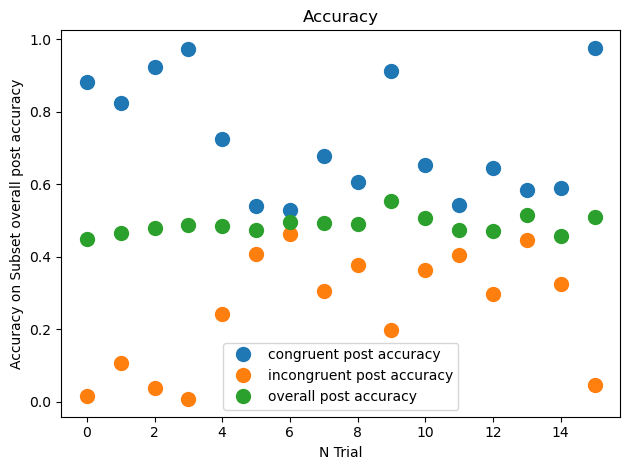

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'Accuracy'}, xlabel='N Trial', ylabel='Accuracy on Subset overall post accuracy'>)

In [173]:
partitions = ['congruent post accuracy', 'incongruent post accuracy', 'overall post accuracy']
xs = []
ys = []
for partition in partitions:
    xs.append([i for i in range(len(df)//2)])
    ys.append(df[partition].to_numpy()[:16])
    labels = []
    # for edit_idx in range(3):
    #     rows = df[df['path'].str.contains('edit_idx_{}'.format(edit_idx))]
        # ys = [rows[label] for label in labels]
    # ys.append(rows[partition])
        # print(rows['path'])
    # labels.append('{} edit images'.format((edit_idx+1) * 2))
    save_path = plot_save_path.format('partition_{}'.format(partition))
    
print(xs)
print(len(ys))

plot(
    xs=xs,
    ys=ys,
    labels=partitions,
    title='Accuracy',
    xlabel='N Trial',
    ylabel='Accuracy on Subset {}'.format(partition),
    save_path=None,
    line=False,
    show=True)


### Code for graphs for learning rate vs accuracy on different test sets

(3, 7) 3 7


<Figure size 640x480 with 0 Axes>

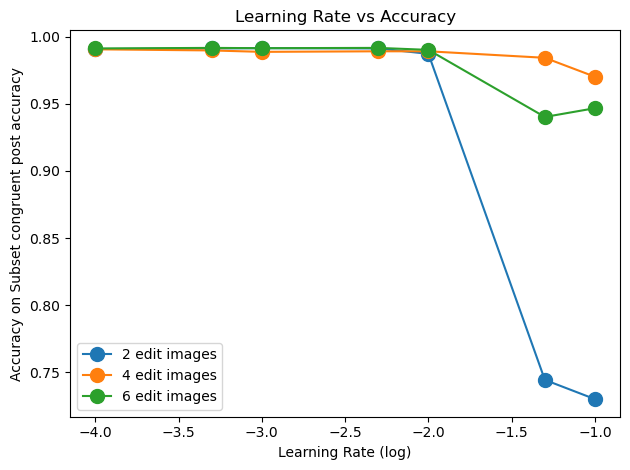

(3, 7) 3 7


<Figure size 640x480 with 0 Axes>

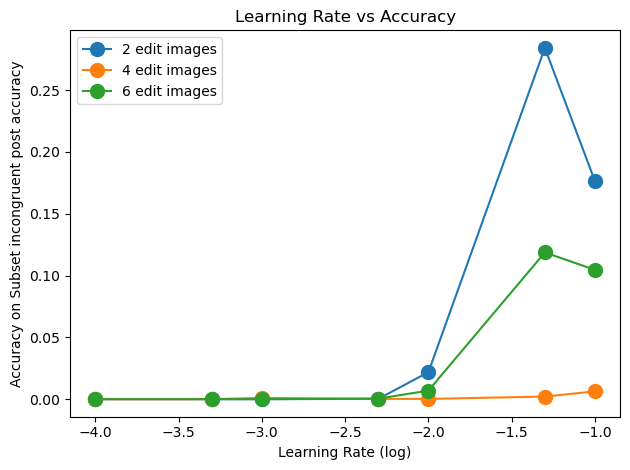

(3, 7) 3 7


<Figure size 640x480 with 0 Axes>

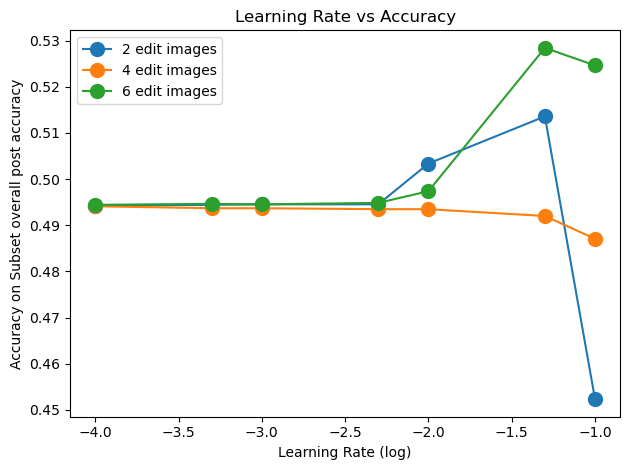

In [90]:
# Print layer number vs congruent post accuracy, incongruent post accuracy, and overall post accuracy
plot_save_path = os.path.join(trial_dir, 'lr_v_accuracy_{}.pdf')

partitions = ['congruent post accuracy', 'incongruent post accuracy', 'overall post accuracy']
for partition in partitions:
    
    xs = [[1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4] for n in range(3)]
    xs = np.log10(xs)
    ys = []
    labels = []
    for edit_idx in range(3):
        rows = df[df['path'].str.contains('edit_idx_{}'.format(edit_idx))]
        # ys = [rows[label] for label in labels]
        ys.append(rows[partition])
        # print(rows['path'])
        labels.append('{} edit images'.format((edit_idx+1) * 2))
    save_path = plot_save_path.format('partition_{}'.format(partition))
    print(xs.shape, len(ys), len(ys[0]))
    plot(
        xs=xs,
        ys=ys,
        labels=labels,
        title='Learning Rate vs Accuracy',
        xlabel='Learning Rate (log)',
        ylabel='Accuracy on Subset {}'.format(partition),
        save_path=save_path,
        show=True)


### Stratify by edit images used

2
0     saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_0
16    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_0
Name: path, dtype: object
0     0.447789
16    0.252421
Name: overall post accuracy, dtype: float64
0     0.881385
16    0.315112
Name: congruent post accuracy, dtype: float64
0     0.016380
16    0.190046
Name: incongruent post accuracy, dtype: float64


<Figure size 640x480 with 0 Axes>

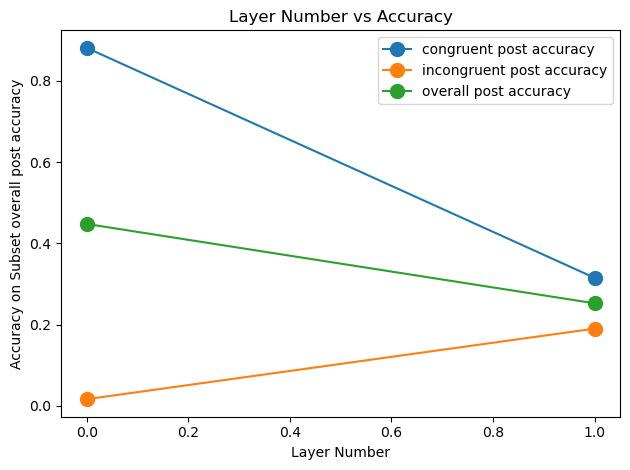

2
1     saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_1
17    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_1
Name: path, dtype: object
1     0.464842
17    0.494211
Name: overall post accuracy, dtype: float64
1     0.825032
17    0.990502
Name: congruent post accuracy, dtype: float64
1     0.106468
17    0.000420
Name: incongruent post accuracy, dtype: float64


<Figure size 640x480 with 0 Axes>

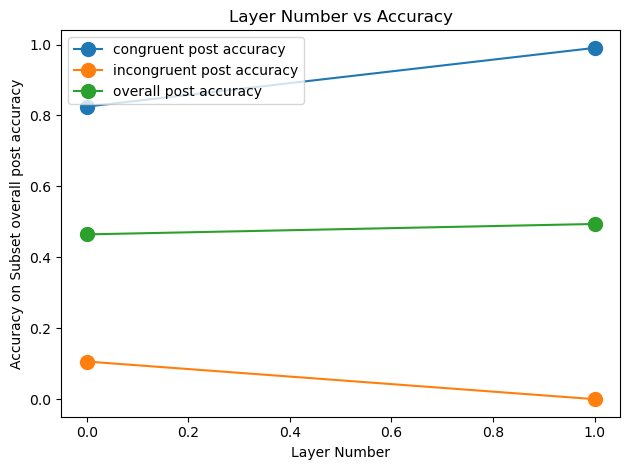

2
2     saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_2
18    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_2
Name: path, dtype: object
2     0.479789
18    0.185895
Name: overall post accuracy, dtype: float64
2     0.923385
18    0.237864
Name: congruent post accuracy, dtype: float64
2     0.038429
18    0.134187
Name: incongruent post accuracy, dtype: float64


<Figure size 640x480 with 0 Axes>

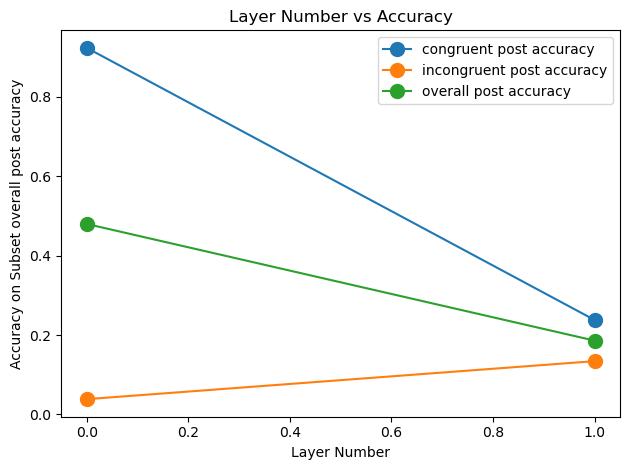

2
3     saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_3
19    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_3
Name: path, dtype: object
3     0.488316
19    0.130842
Name: overall post accuracy, dtype: float64
3     0.971929
19    0.178134
Name: congruent post accuracy, dtype: float64
3     0.007140
19    0.083788
Name: incongruent post accuracy, dtype: float64


<Figure size 640x480 with 0 Axes>

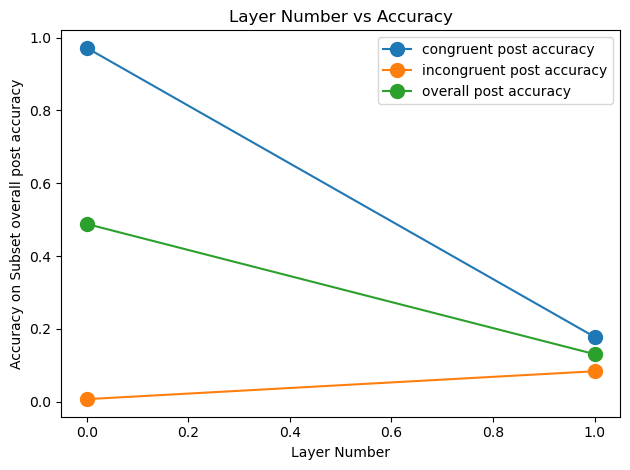

2
4     saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_4
20    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_4
Name: path, dtype: object
4     0.483474
20    0.493158
Name: overall post accuracy, dtype: float64
4     0.725623
20    0.988814
Name: congruent post accuracy, dtype: float64
4     0.242545
20    0.000000
Name: incongruent post accuracy, dtype: float64


<Figure size 640x480 with 0 Axes>

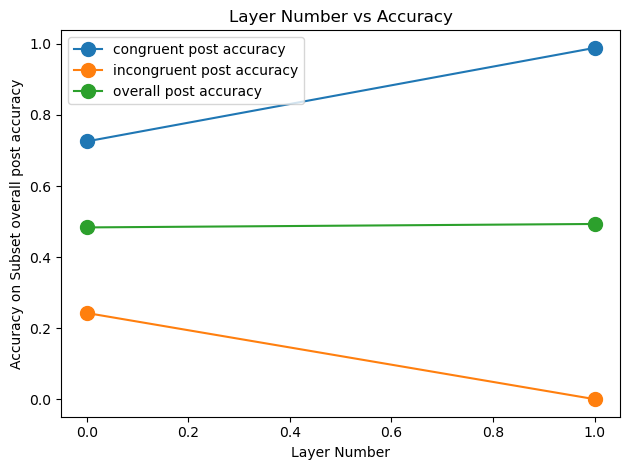

2
5     saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_5
21    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_5
Name: path, dtype: object
5     0.472842
21    0.163474
Name: overall post accuracy, dtype: float64
5     0.538835
21    0.194597
Name: congruent post accuracy, dtype: float64
5     0.407182
21    0.132507
Name: incongruent post accuracy, dtype: float64


<Figure size 640x480 with 0 Axes>

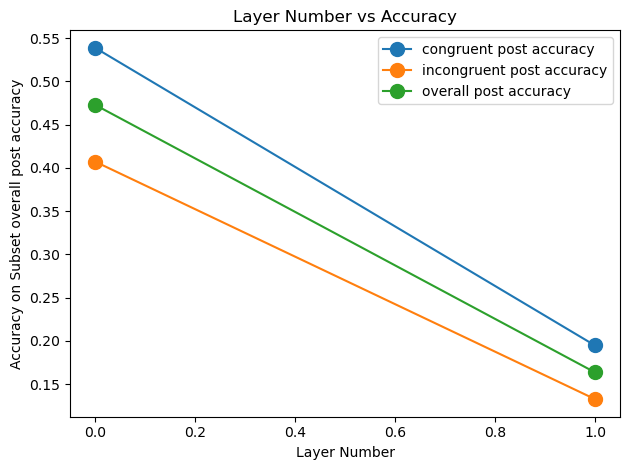

2
6     saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_6
22    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_6
Name: path, dtype: object
6     0.496421
22    0.094842
Name: overall post accuracy, dtype: float64
6     0.529337
22    0.110384
Name: congruent post accuracy, dtype: float64
6     0.463671
22    0.079378
Name: incongruent post accuracy, dtype: float64


<Figure size 640x480 with 0 Axes>

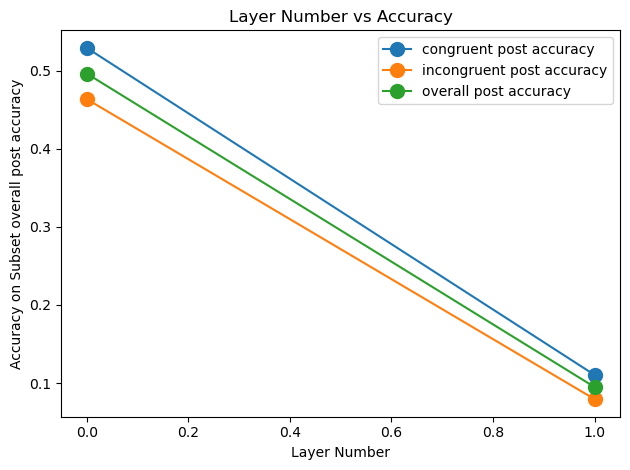

2
7     saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_7
23    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_7
Name: path, dtype: object
7     0.492000
23    0.119895
Name: overall post accuracy, dtype: float64
7     0.678345
23    0.154285
Name: congruent post accuracy, dtype: float64
7     0.306594
23    0.085678
Name: incongruent post accuracy, dtype: float64


<Figure size 640x480 with 0 Axes>

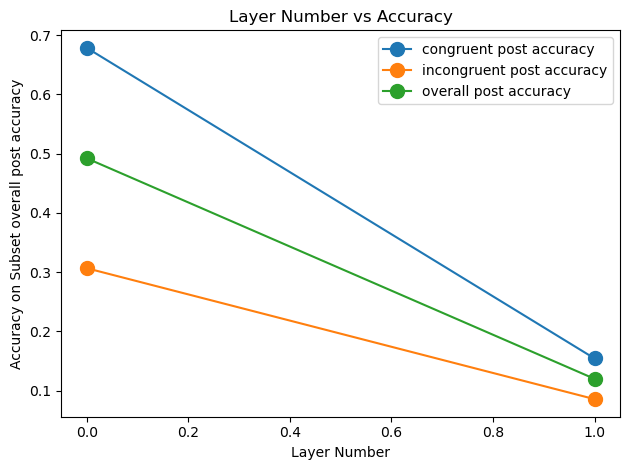

2
8     saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_8
24    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_8
Name: path, dtype: object
8     0.491474
24    0.076737
Name: overall post accuracy, dtype: float64
8     0.60553
24    0.10954
Name: congruent post accuracy, dtype: float64
8     0.377992
24    0.044099
Name: incongruent post accuracy, dtype: float64


<Figure size 640x480 with 0 Axes>

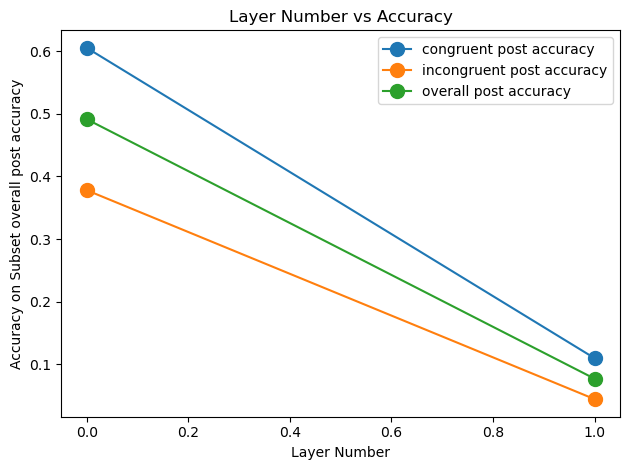

2
9     saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_9
25    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_9
Name: path, dtype: object
9     0.553053
25    0.493789
Name: overall post accuracy, dtype: float64
9     0.911144
25    0.990080
Name: congruent post accuracy, dtype: float64
9     0.196766
25    0.000000
Name: incongruent post accuracy, dtype: float64


<Figure size 640x480 with 0 Axes>

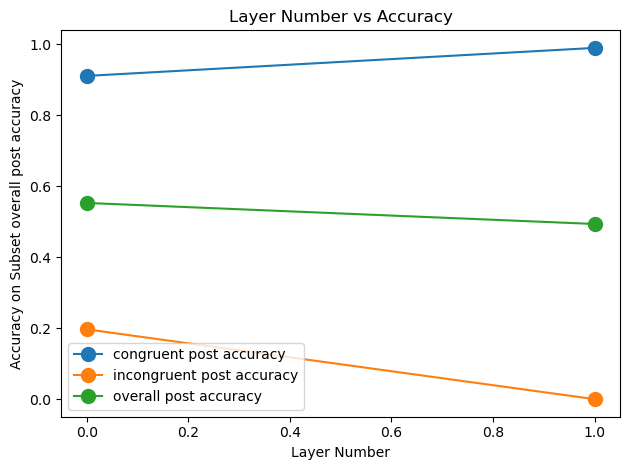

2
10    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_10
26    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_10
Name: path, dtype: object
10    0.507895
26    0.493158
Name: overall post accuracy, dtype: float64
10    0.654285
26    0.988814
Name: congruent post accuracy, dtype: float64
10    0.362243
26    0.000000
Name: incongruent post accuracy, dtype: float64


<Figure size 640x480 with 0 Axes>

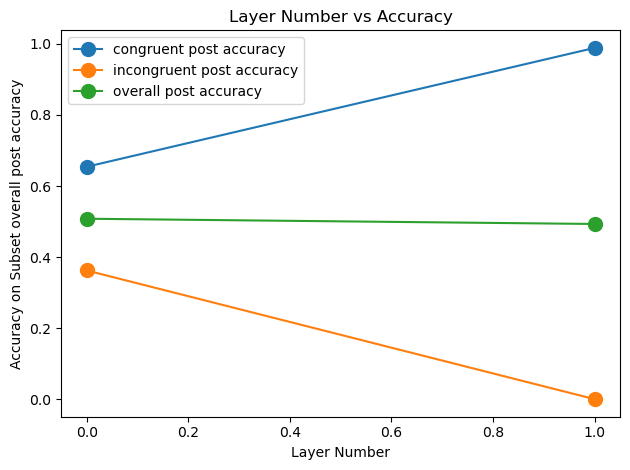

2
11    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_11
27    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_11
Name: path, dtype: object
11    0.473789
27    0.203368
Name: overall post accuracy, dtype: float64
11    0.543056
27    0.246306
Name: congruent post accuracy, dtype: float64
11    0.404872
27    0.160647
Name: incongruent post accuracy, dtype: float64


<Figure size 640x480 with 0 Axes>

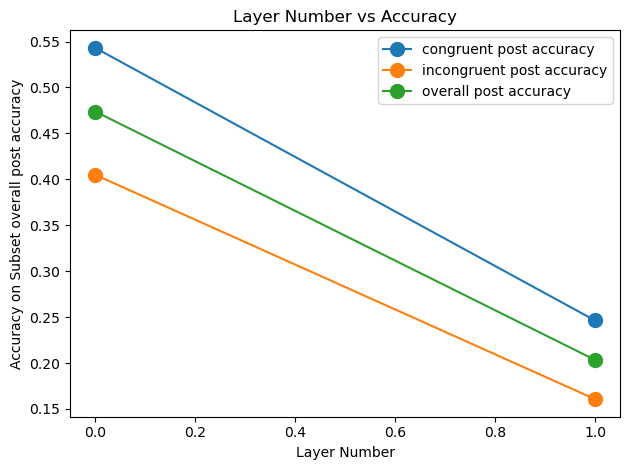

2
12    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_12
28    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_12
Name: path, dtype: object
12    0.471053
28    0.086947
Name: overall post accuracy, dtype: float64
12    0.644365
28    0.097087
Name: congruent post accuracy, dtype: float64
12    0.298614
28    0.076858
Name: incongruent post accuracy, dtype: float64


<Figure size 640x480 with 0 Axes>

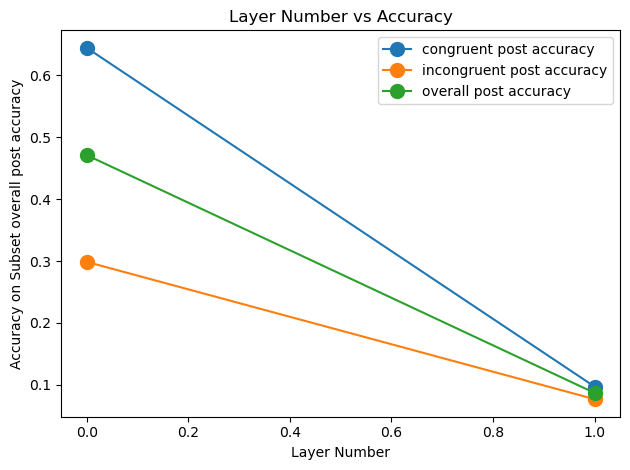

2
13    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_13
29    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_13
Name: path, dtype: object
13    0.515158
29    0.148000
Name: overall post accuracy, dtype: float64
13    0.583369
29    0.217602
Name: congruent post accuracy, dtype: float64
13    0.447291
29    0.078748
Name: incongruent post accuracy, dtype: float64


<Figure size 640x480 with 0 Axes>

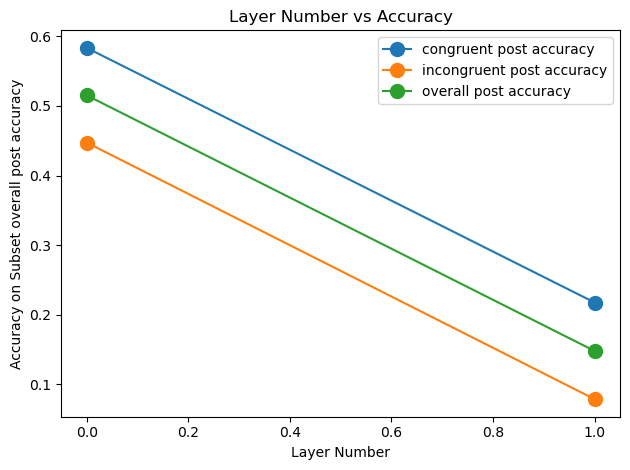

2
14    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_14
30    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_14
Name: path, dtype: object
14    0.457579
30    0.085053
Name: overall post accuracy, dtype: float64
14    0.590333
30    0.109118
Name: congruent post accuracy, dtype: float64
14    0.325493
30    0.061109
Name: incongruent post accuracy, dtype: float64


<Figure size 640x480 with 0 Axes>

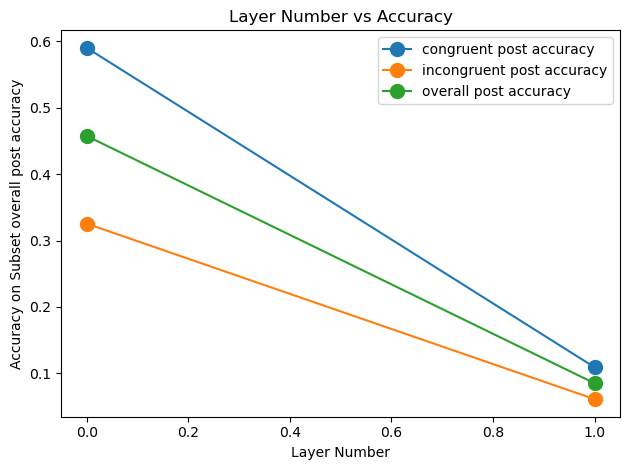

2
15    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_0/results/edit_idx_15
31    saved/edit_2_Spurious_MNIST/method_eac/LeNet-patches/0324_170216/layernum_1/results/edit_idx_15
Name: path, dtype: object
15    0.510000
31    0.492211
Name: overall post accuracy, dtype: float64
15    0.976150
31    0.986914
Name: congruent post accuracy, dtype: float64
15    0.046199
31    0.000000
Name: incongruent post accuracy, dtype: float64


<Figure size 640x480 with 0 Axes>

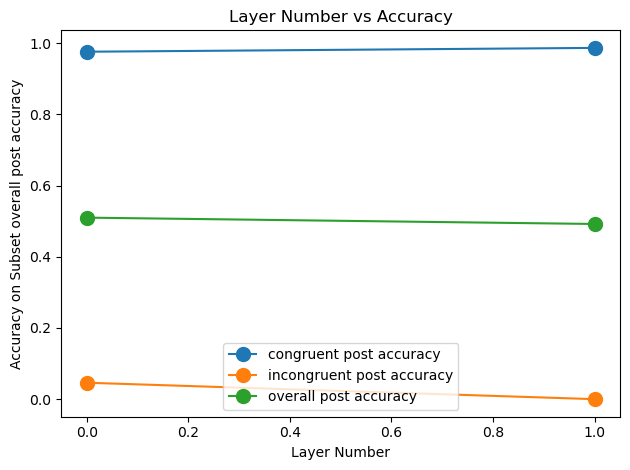

In [171]:
iv_name = 'Layer Number'
iv_values = [0, 1]
n_conditions = len(iv_values)
n_trials = 16

pd.set_option('display.max_colwidth', None)
for n_trial in range(n_trials):
    trial_df = df.iloc[n_trial::n_trials, :]
    print(len(trial_df))
    print(trial_df['path'])
    print(trial_df['overall post accuracy'])
    print(trial_df['congruent post accuracy'])
    print(trial_df['incongruent post accuracy'])
    
    partitions = ['congruent post accuracy', 'incongruent post accuracy', 'overall post accuracy']
    xs = [iv_values for n in range(3)]
    ys = []
    labels = []
    for partition in partitions:
        
        # for edit_idx in range(3):
            # rows = df[df['path'].str.contains('edit_idx_{}'.format(edit_idx))]
            # ys = [rows[label] for label in labels]
        ys.append(trial_df[partition])
            # print(rows['path'])
            # labels.append('{} edit images'.format((edit_idx+1) * 2))
        save_path = plot_save_path.format('partition_{}'.format(partition))
        # print(xs.shape, len(ys), len(ys[0]))
    plot(
        xs=xs,
        ys=ys,
        labels=partitions,
        title='{} vs Accuracy'.format(iv_name),
        xlabel='{}'.format(iv_name),
        ylabel='Accuracy on Subset {}'.format(partition),
        save_path=None,
        show=True)